# Multiple trials

In [336]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport link
%aimport graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

In [338]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [528]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
vLGPcolor = sns.xkcd_rgb["denim blue"]

In [351]:
samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")

## Lorenz latent

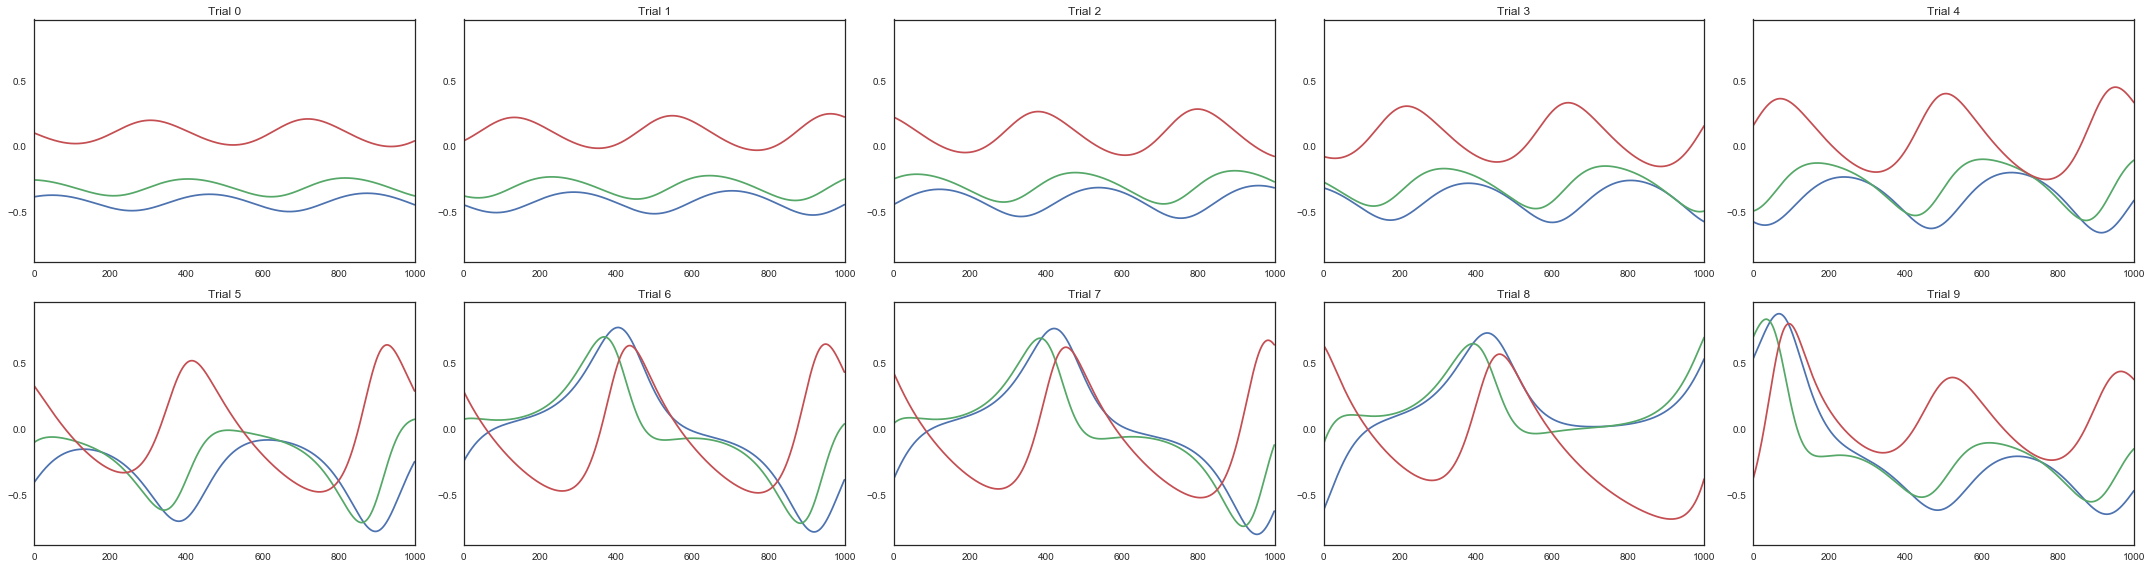

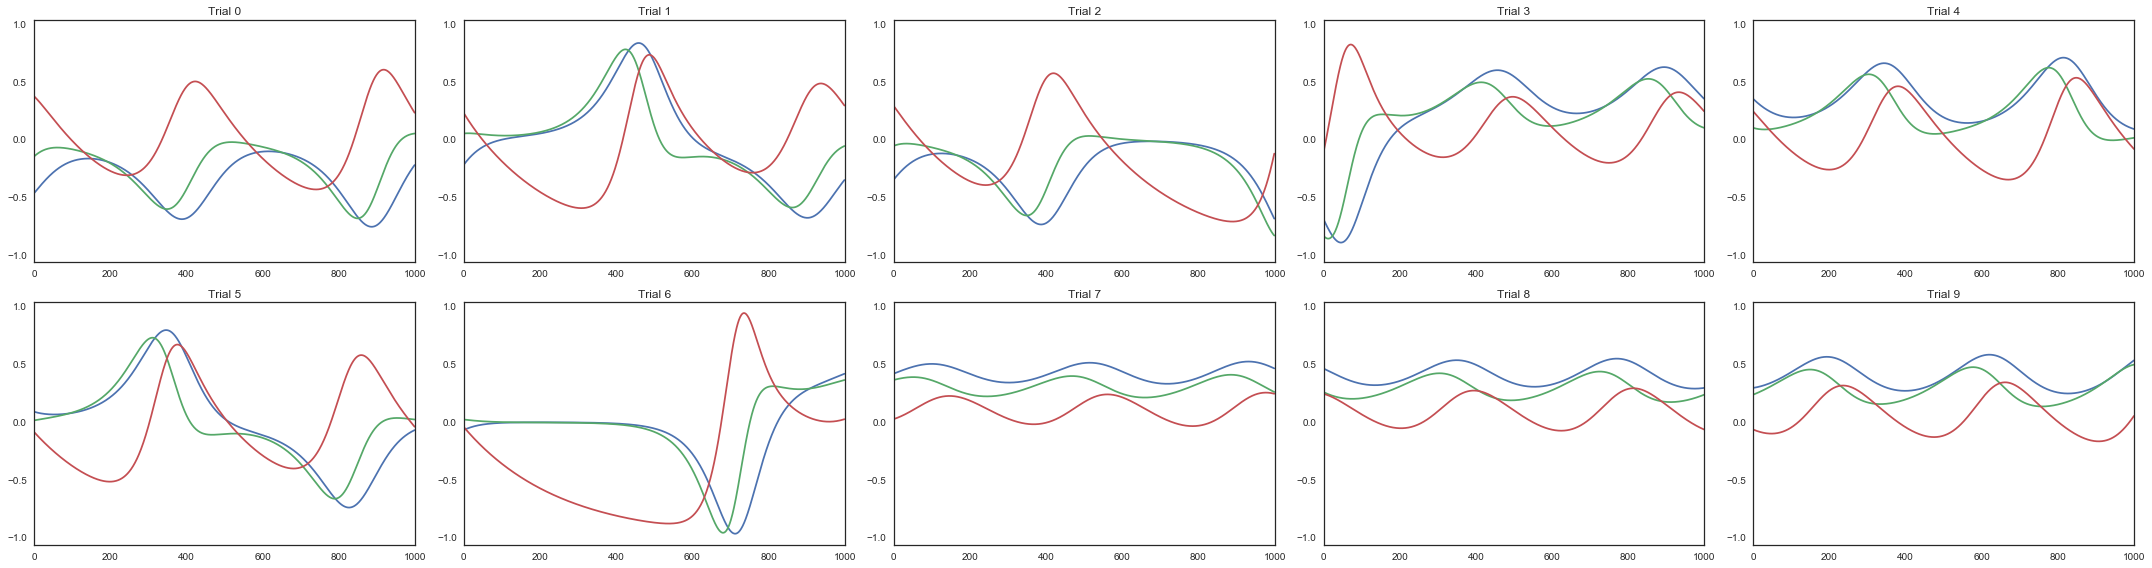

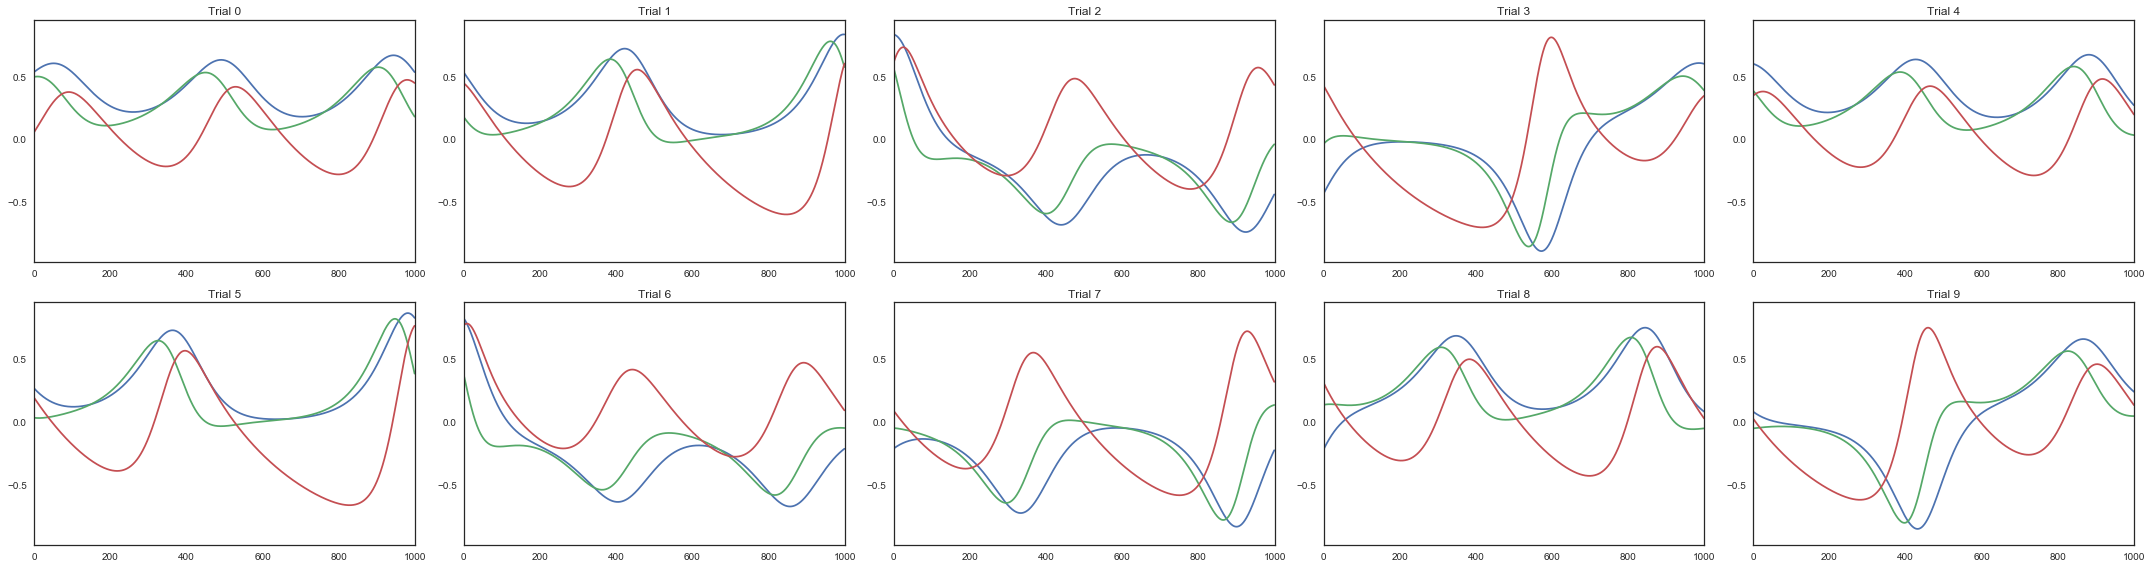

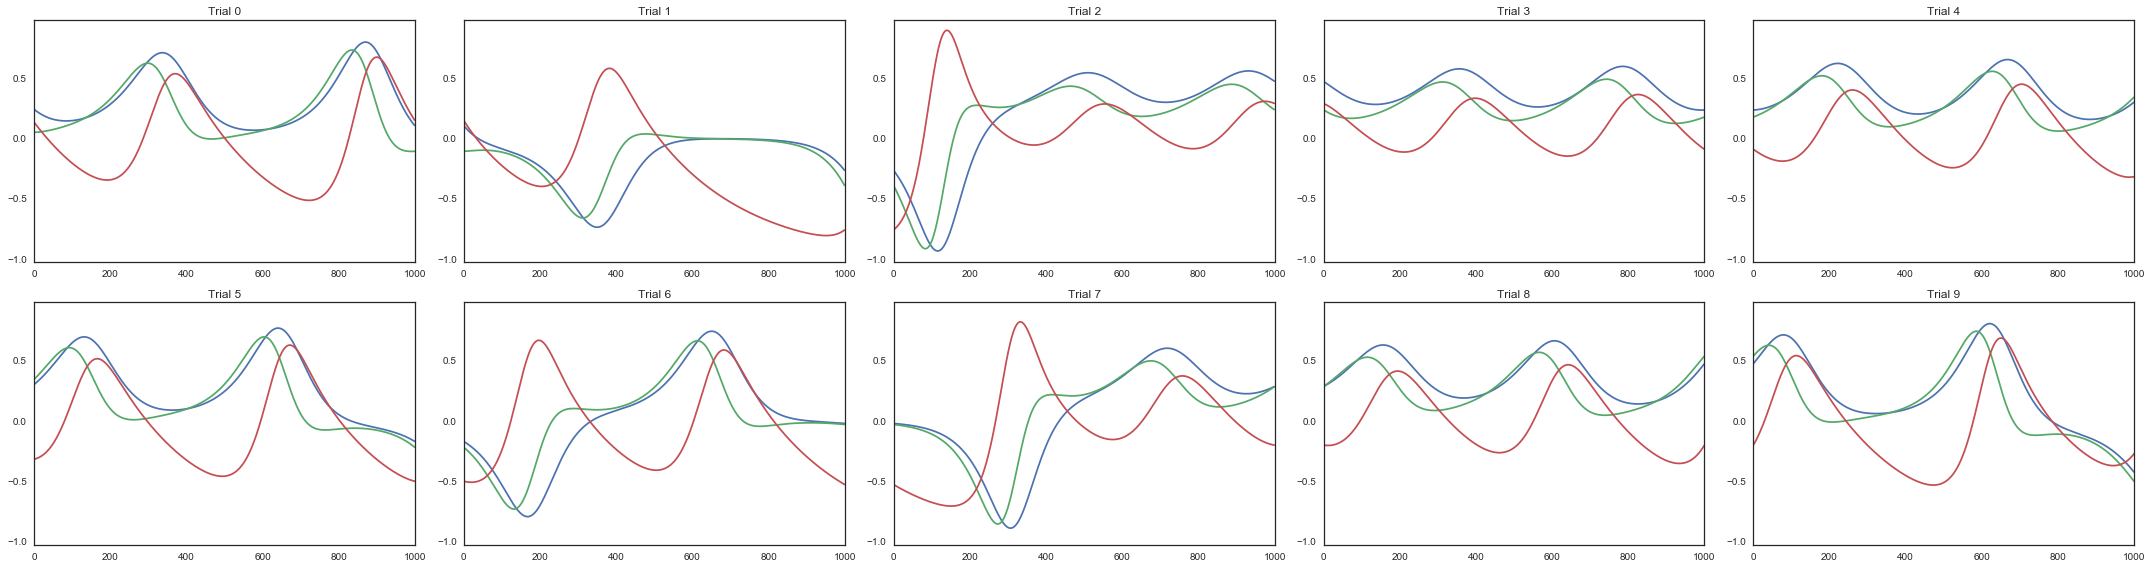

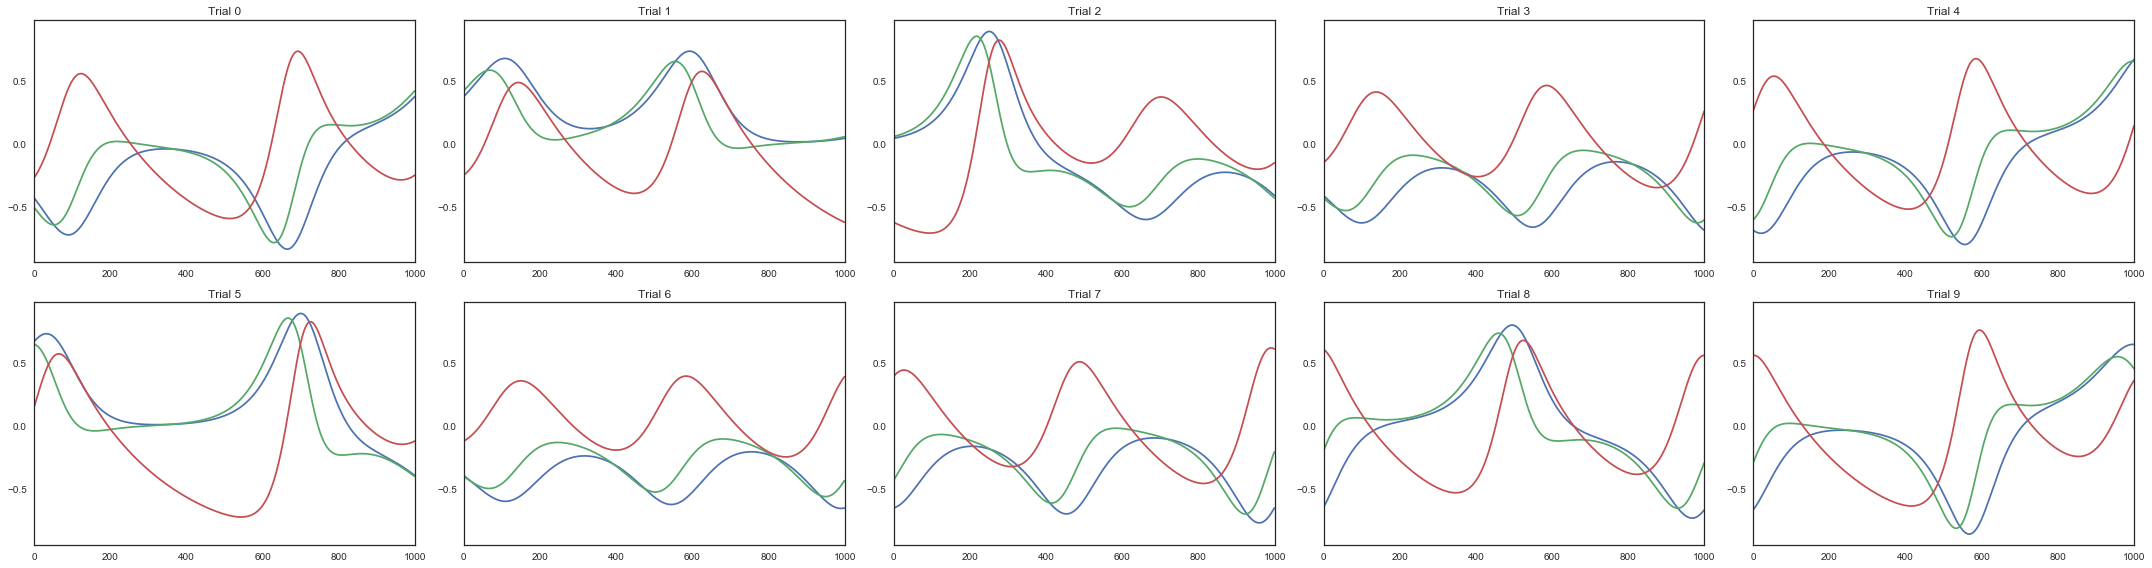

In [356]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + nsample * ntrial * ntime, dt=1.5e-3, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((nsample, ntrial, ntime, -1))
for i in range(5):
    graph.dynplot(x[i, :], ncol=5)

# Simulate spike trains

mean firing rate per neuron [[ 20.   0.   0. ...,   0.   0.   0.]
 [ 20.  20.   0. ...,   0.   0.   0.]
 [  0.  20.   0. ...,   0.  20.   0.]
 ..., 
 [  0.   0.   0. ...,   0.   0.   0.]
 [ 40.   0.  20. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  20.   0.   0.]]
mean firing rate per neuron [[ 40.  20.  20. ...,   0.   0.  40.]
 [ 20.  20.  20. ...,   0.   0.  20.]
 [  0.  20.   0. ...,  20.  20.   0.]
 ..., 
 [  0.   0.   0. ...,   0.  20.   0.]
 [ 40.   0.  20. ...,  20.   0.   0.]
 [  0.  20.   0. ...,  20.  20.  20.]]
mean firing rate per neuron [[ 40.  20.  20. ...,  60.   0.  60.]
 [ 20.  20.  20. ...,  20.  20.  40.]
 [  0.  20.   0. ...,  20.  40.   0.]
 ..., 
 [  0.   0.   0. ...,   0.  40.  20.]
 [ 40.   0.  20. ...,  40.  20.   0.]
 [  0.  20.   0. ...,  20.  40.  60.]]
mean firing rate per neuron [[ 40.  20.  20. ...,  60.   0.  60.]
 [ 40.  20.  20. ...,  20.  40.  40.]
 [  0.  20.   0. ...,  60.  40.   0.]
 ..., 
 [  0.  20.   0. ...,   0.  40.  20.]
 [ 40.  20.  20. ...,

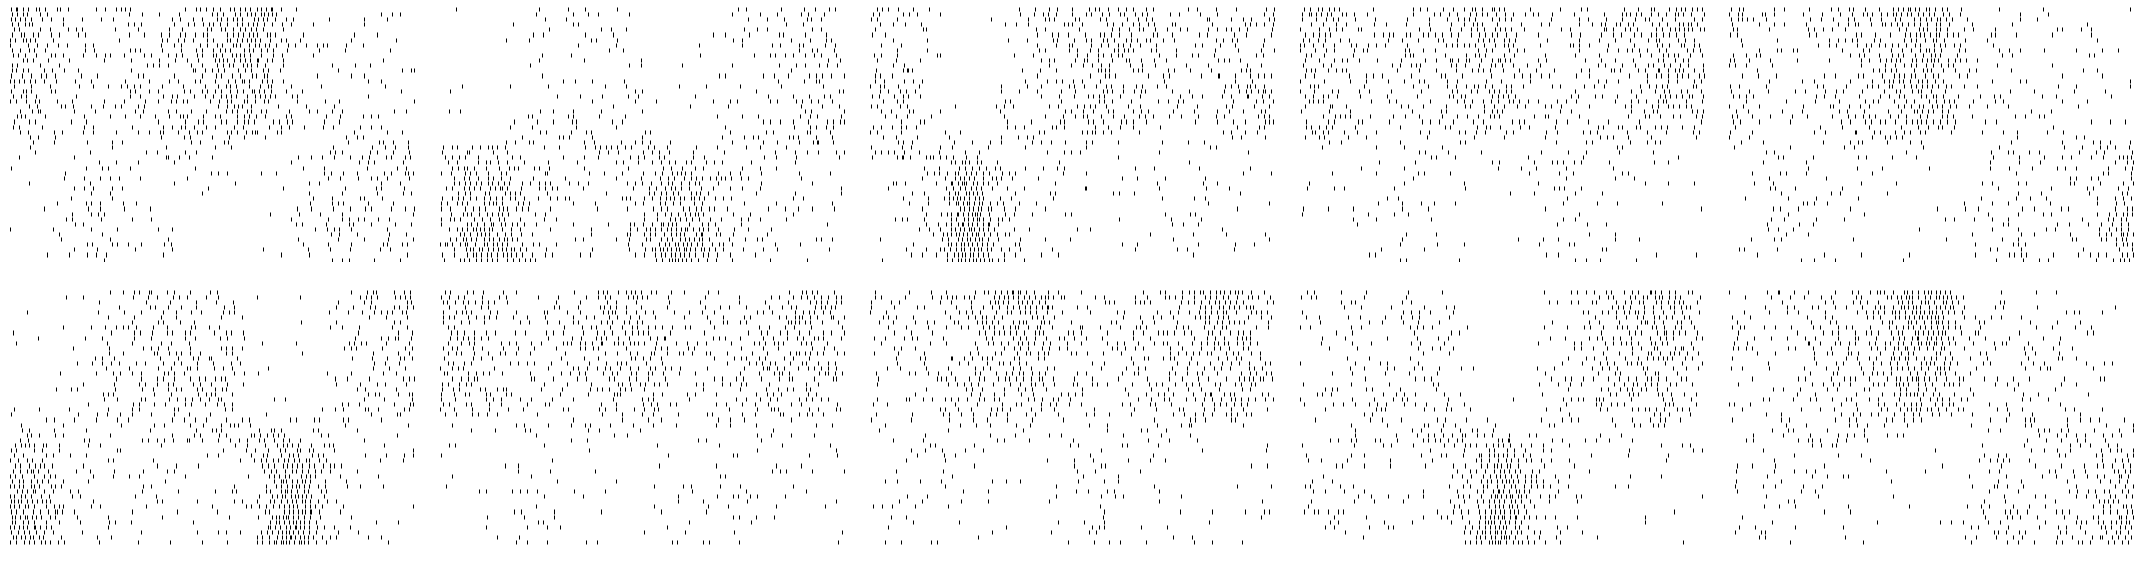

In [480]:
np.random.seed(0)
low = np.log(15 / ntime)
aspk = np.sort((np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike)), axis=1)
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike), 
                  -3 * np.ones(nspike), -3 * np.ones(nspike), -3 * np.ones(nspike), -2 * np.ones(nspike),
                  -2 * np.ones(nspike), -1 * np.ones(nspike), -1 * np.ones(nspike)))

y = np.empty((nsample, ntrial, ntime, nspike))  # spike trains
rate = np.empty_like(y)  # firing rates
LorenzSample = []
fsample = []

for i in range(nsample):
    y[i, :], _, rate[i, :] = simulation.spike(x[i, :], aspk, bspk)
    print('mean firing rate per neuron', y.mean(axis=(0, 1)) * 1000)
    LorenzSample.append({'y': y[i, :], 'rate': rate[i, :], 'x': x[i, :], 'a': aspk, 'b':bspk})
    fname = '{}/lorenz_{}'.format(samplepath, i + 1)
    fsample.append(fname)
    savemat(fname, LorenzSample[i])
graph.rasterplot(y[nsample - 1, :], ncol=5);

In [481]:
fLorenzSample = ['{}/lorenz_{}'.format(samplepath, i + 1) for i in range(nsample)]
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=1e-5)

# vLGPAngle = pd.DataFrame(columns=['LatentAngle', 'LoadingAngle', 'Time', 'Model', 'Sample'])
for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sample = loadmat(fname, squeeze_me=True)
    result = inference.multitrials(sample['y'], None, sigma, omega, x=sample['x'], 
                                   ta=sample['a'], tb=sample['b'], lag=10, rank=100, 
                                   niter=100, tol=1e-5, verbose=False)
    savemat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), result)
#     df = pd.DataFrame(np.vstack((rad2deg(result['stat']['latentAngle'][1:]), 
#                       rad2deg(result['stat']['loadingAngle'][1:]), 
#                       np.cumsum(result['stat']['elapsed'][1:, 2]))).T, 
#                       columns=['LatentAngle', 'LoadingAngle', 'Time'])
#     df['Model'] = 'vLGP'
#     df['Sample'] = i + 1
#     vLGPAngle = vLGPAngle.append(df)
print('Done.')

# Collect results
Lorenz_vLGP = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_vLGP.append(loadmat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
26 iterations, ELBO: -55814.6251, elapsed: 33.21, converged: True

Sample 2
26 iterations, ELBO: -59054.3324, elapsed: 33.18, converged: True

Sample 3
18 iterations, ELBO: -58296.8321, elapsed: 23.16, converged: True

Sample 4
18 iterations, ELBO: -58110.0716, elapsed: 22.96, converged: True

Sample 5
20 iterations, ELBO: -57038.8528, elapsed: 25.26, converged: True

Done.


Sample 3
Latent subspace angle: 45.02 deg
Loading subspace angle: 83.41 deg
45.0191084159


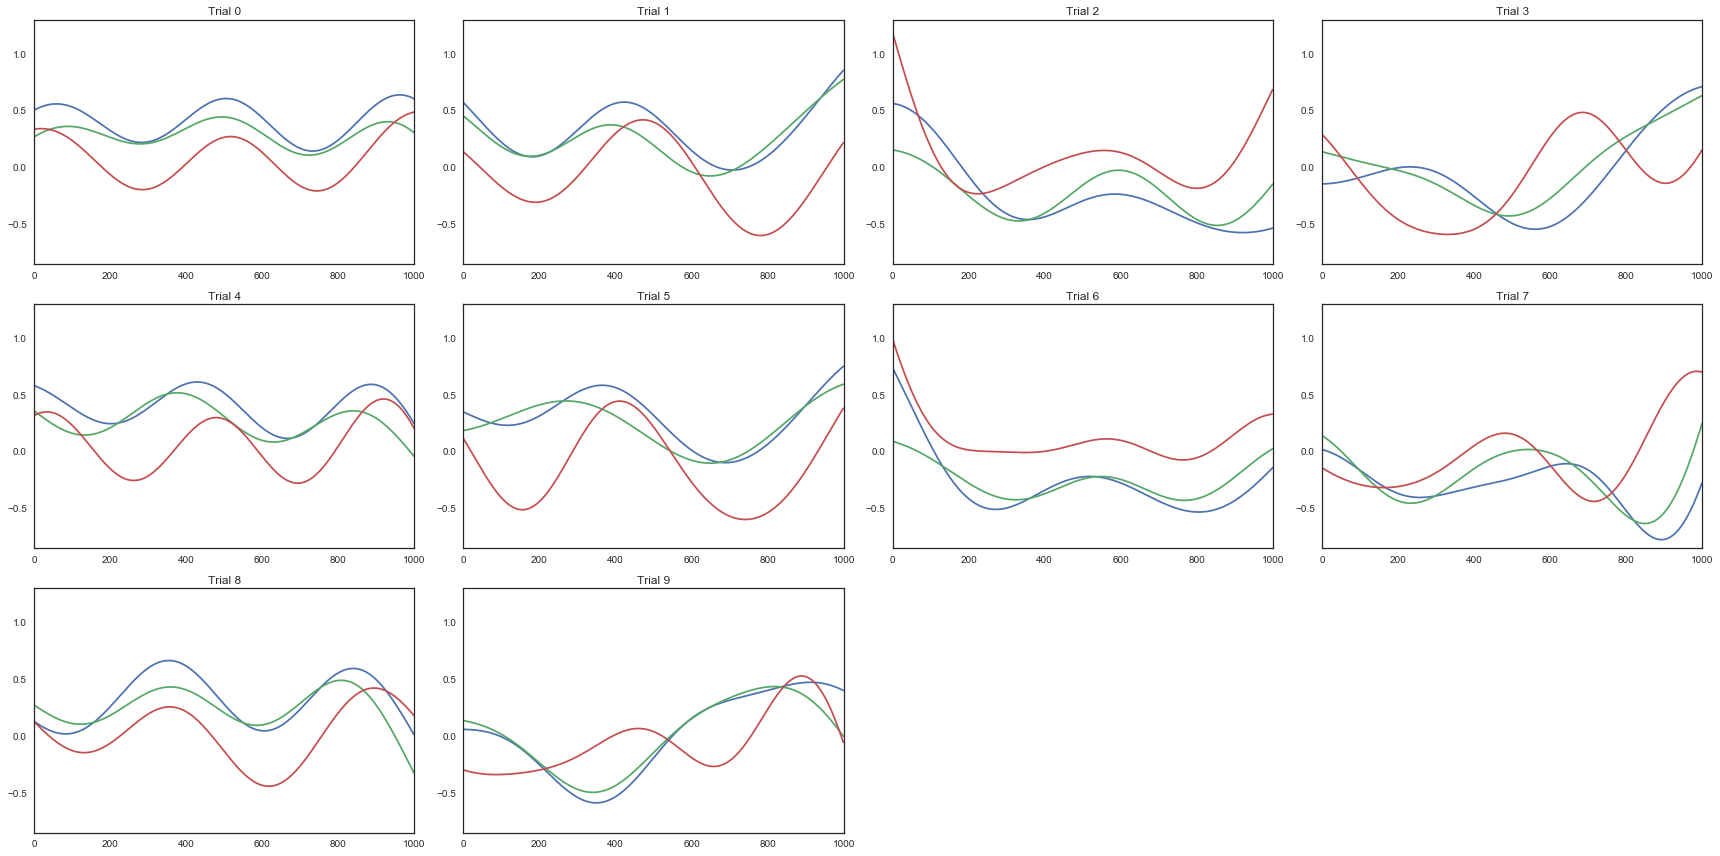

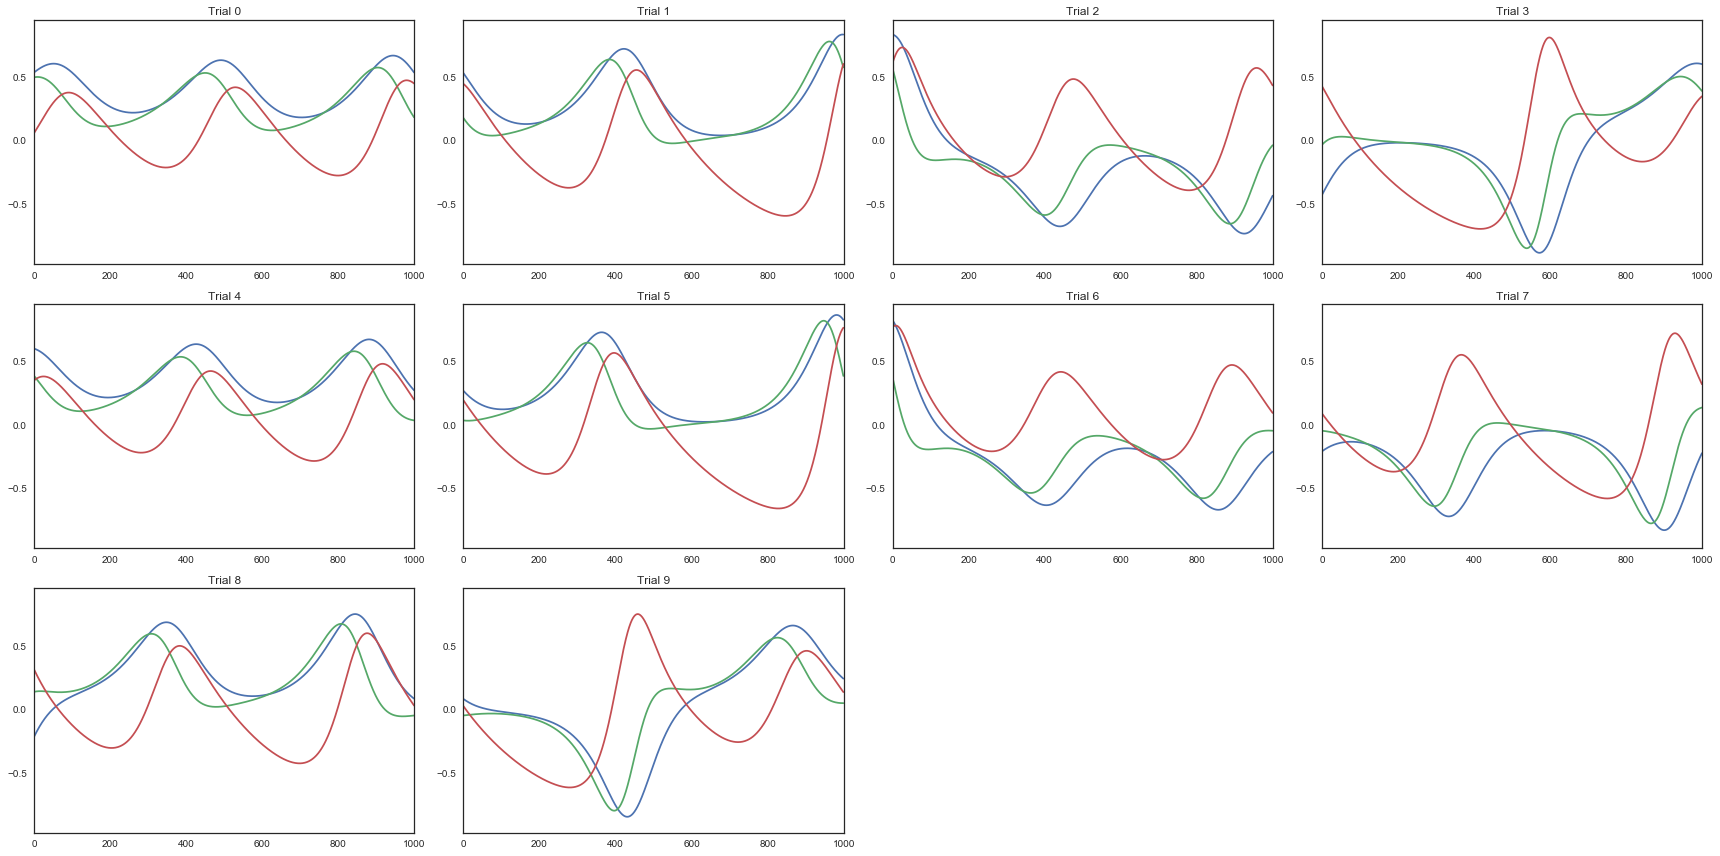

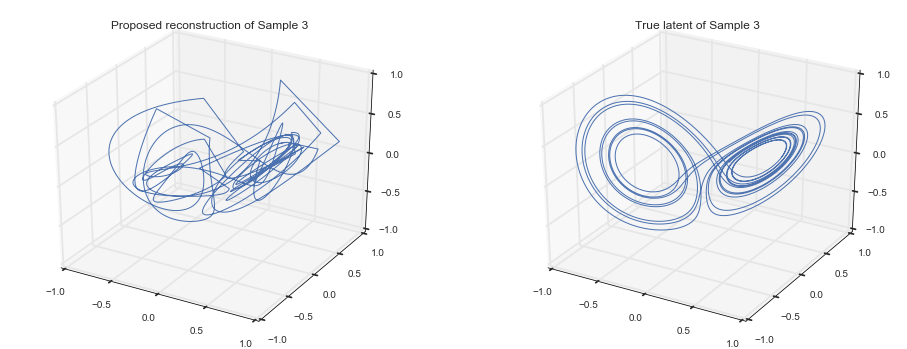

In [523]:
idx = np.array([r['latentAngle'][-1] for r in Lorenz_vLGP]).argmin()
# idx = 2
print('Sample {}'.format(idx + 1))
bestvLGP = vLGPres[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['loadingAngle'][-1])))
# bestvLGPx = util.align(bestvLGP['mu'])
bestvLGPx = bestvLGP['mu']
rotated = np.empty_like(bestvLGPx)
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestvLGPx[i, :]), bestvLGP['x'][i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestvLGP['x'].reshape((-1, nlatent)))))
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestvLGP['x'])

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
recon = rotated.reshape((-1, nlatent))
ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax[0].set_xlim3d(-1, 1);
ax[0].set_ylim3d(-1, 1);
ax[0].set_zlim3d(-1, 1);
ax[0].set_title('Proposed reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestvLGP['x'].reshape((-1, nlatent))[:, 0], bestvLGP['x'].reshape((-1, nlatent))[:, 1], bestvLGP['x'].reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

In [534]:
# Run GPFA before loading GPFA results
Lorenz_GPFA = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_GPFA.append(loadmat('{}/lorenz_{}_GPFA'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Latent subspace angle: 60.03 deg
Loading subspace angle: 80.50 deg
50.3027709059


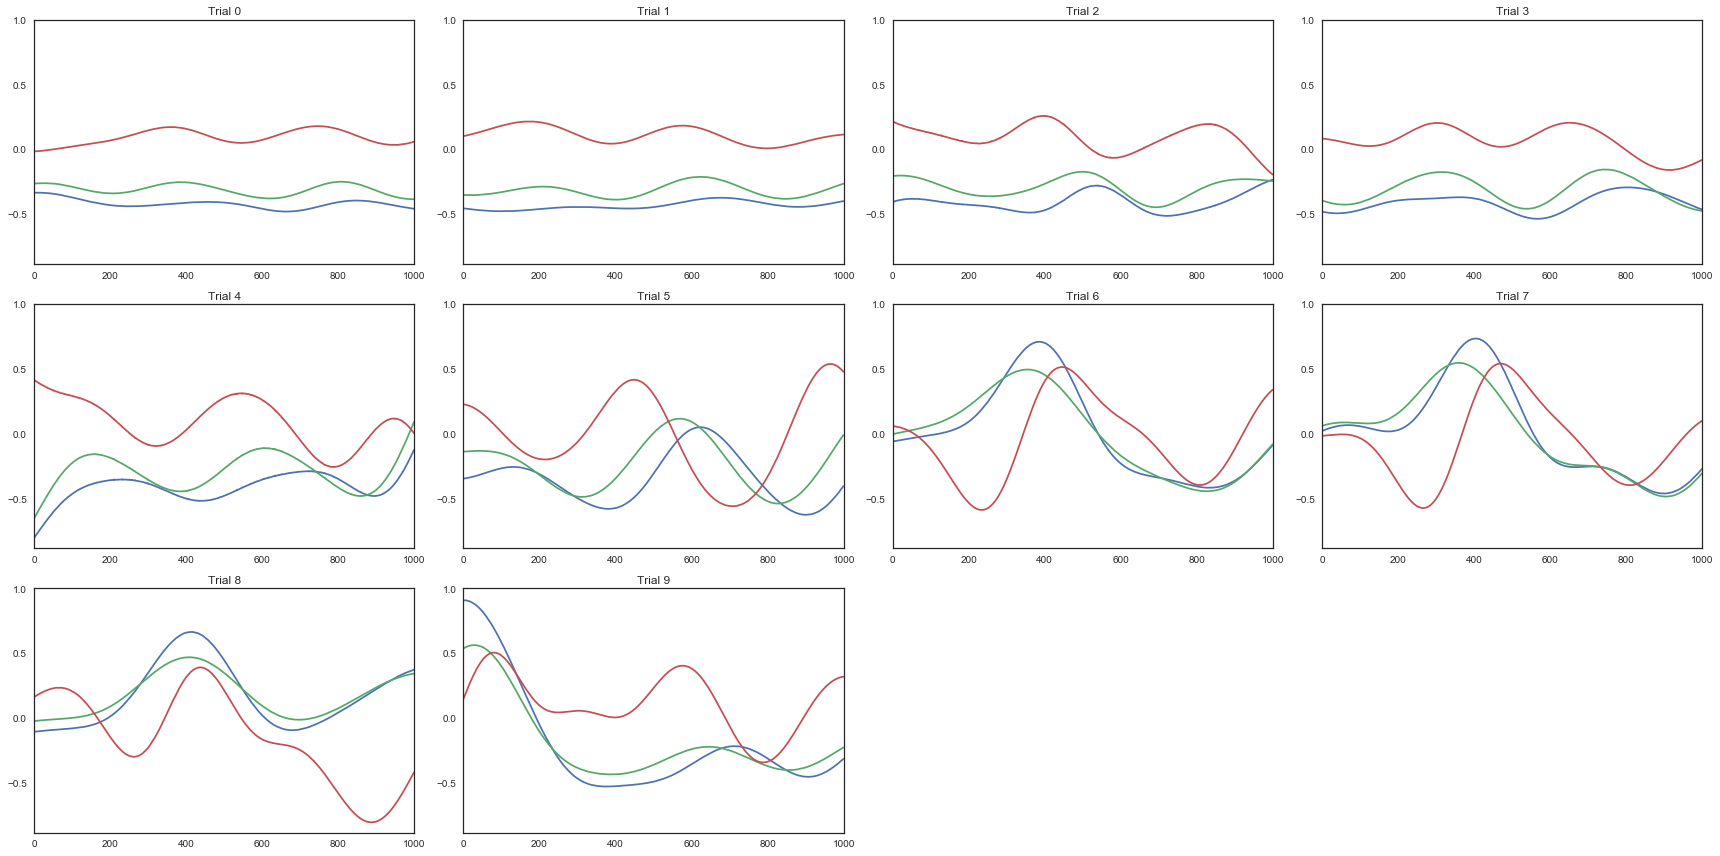

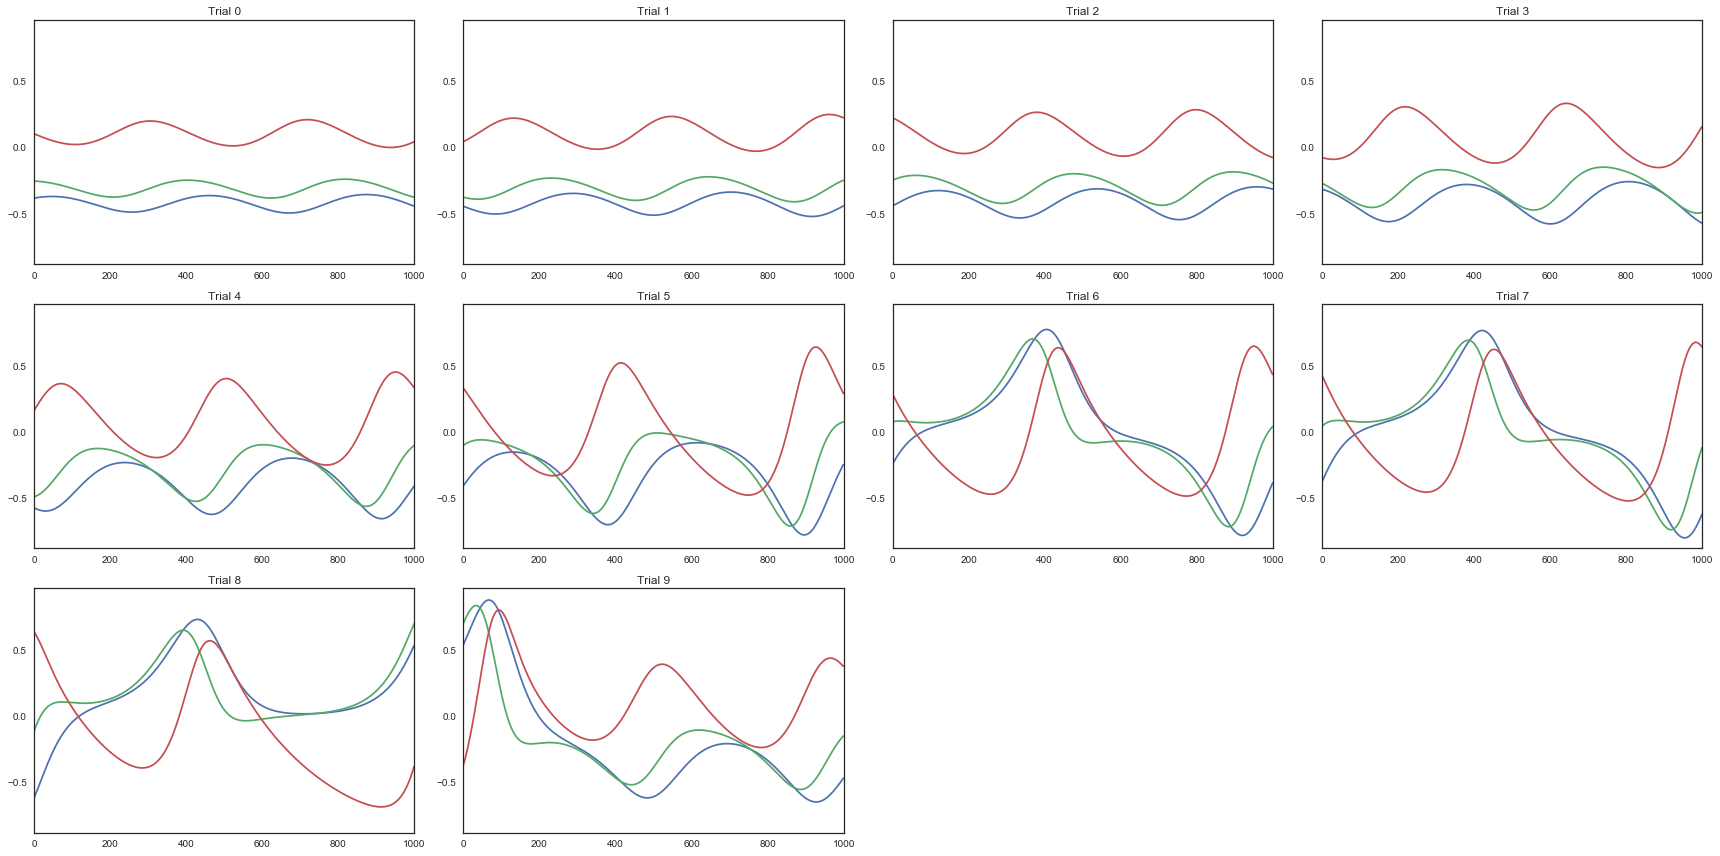

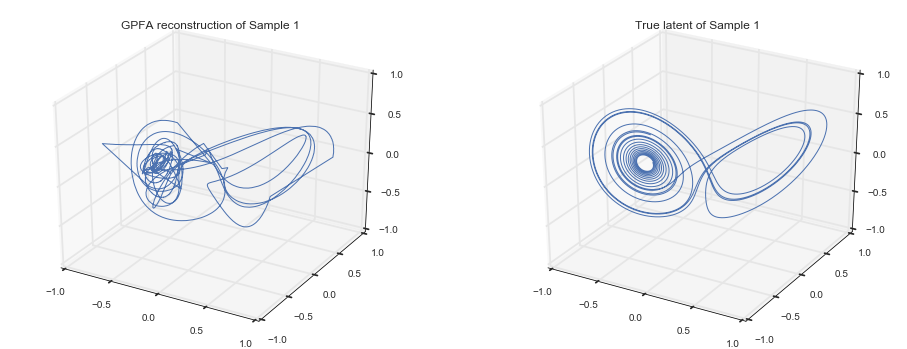

In [535]:
idx = np.array([r['latentAngle'][-1] for r in Lorenz_GPFA]).argmin()
print('Sample {}'.format(idx + 1))
bestGPFA = Lorenz_GPFA[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestGPFA['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestGPFA['loadingAngle'][-1])))
bestmu = np.rollaxis(np.dstack(bestGPFA['seqTrain']['xsm']), axis=-1).transpose((0, 2, 1))
bestx = np.rollaxis(np.dstack(bestGPFA['seqTrain']['x']), axis=-1).transpose((0, 2, 1))
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestx.reshape((-1, nlatent)))))
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestx)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
recon = rotated.reshape((-1, nlatent))
ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax[0].set_xlim3d(-1, 1);
ax[0].set_ylim3d(-1, 1);
ax[0].set_zlim3d(-1, 1);
ax[0].set_title('GPFA reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestx.reshape((-1, nlatent))[:, 0], bestx.reshape((-1, nlatent))[:, 1], bestx.reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

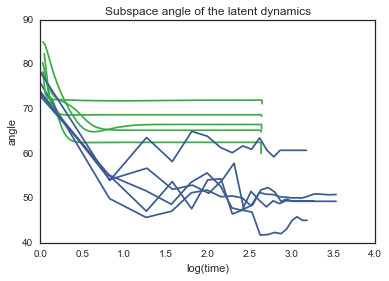

In [536]:
plt.figure();
for i in range(nsample):
    Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['elapsed'][0, :] = 1
    plt.plot(np.log(np.cumsum(Lorenz_GPFA[i]['iterTime'])), rad2deg(Lorenz_GPFA[i]['latentAngle']), color=GPFAcolor);
    plt.plot(np.log(np.cumsum(Lorenz_vLGP[i]['elapsed'][:,2])), rad2deg(Lorenz_vLGP[i]['latentAngle']), color=vLGPcolor);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the latent dynamics');
# plt.legend();

# plt.figure()
# plt.plot(np.log(np.cumsum(bestGPFA['iterTime'])), rad2deg(bestGPFA['loadingAngle']), label='GPFA');
# plt.plot(np.log(np.cumsum(bestvLGP['elapsed'][:,2])), rad2deg(bestvLGP['loadingAngle']), label='Proposed');
# plt.xlabel('log(time)');
# plt.ylabel('angle');
# plt.title('Subspace angle of the loading matrix');
# plt.legend();

# PLDS samples

In [482]:
fPLDSSample = ['{}/PLDS_{}'.format(samplepath, i + 1) for i in range(nsample)]
PLDSSample = []
for i, fname in enumerate(fPLDSSample):
    mat = loadmat(fname, squeeze_me=True)
    d = {'x': np.rollaxis(np.dstack(mat['seqOrig']['x']), axis=-1).transpose((0, 2, 1)),
         'y': np.rollaxis(np.dstack(mat['seqOrig']['y']), axis=-1).transpose((0, 2, 1)), 
         'a': mat['a'],
         'b': mat['b'][None, ...]}
    PLDSSample.append(d)

In [478]:
sigma = np.full(nlatent, fill_value=1.0)
omega = np.full(nlatent, fill_value=1e-3)

for i, sample in enumerate(PLDSSample):
    print('Sample {}'.format(i + 1))
    result = inference.multitrials(sample['y'], None, sigma, omega, x=sample['x'], 
                                   ta=sample['a'], tb=sample['b'], lag=10, rank=100, 
                                   niter=100, tol=1e-5, verbose=False)
    savemat('{}/PLDS_{}_vLGP'.format(outputpath, i + 1), result)
print('Done.')

# Collect results
PLDS_vLGP = []
for i, sample in enumerate(PLDSSample):
    PLDS_vLGP.append(loadmat('{}/PLDS_{}_vLGP'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
24 iterations, ELBO: -92624.6170, elapsed: 47.17, converged: True

Sample 2
28 iterations, ELBO: -91368.2253, elapsed: 55.40, converged: True

Sample 3
45 iterations, ELBO: -89537.4550, elapsed: 88.63, converged: True

Sample 4
35 iterations, ELBO: -89090.7443, elapsed: 69.35, converged: True

Sample 5
30 iterations, ELBO: -91561.5631, elapsed: 59.01, converged: True

Done.


Sample 2
Latent subspace angle: 48.13 deg
Loading subspace angle: 34.19 deg


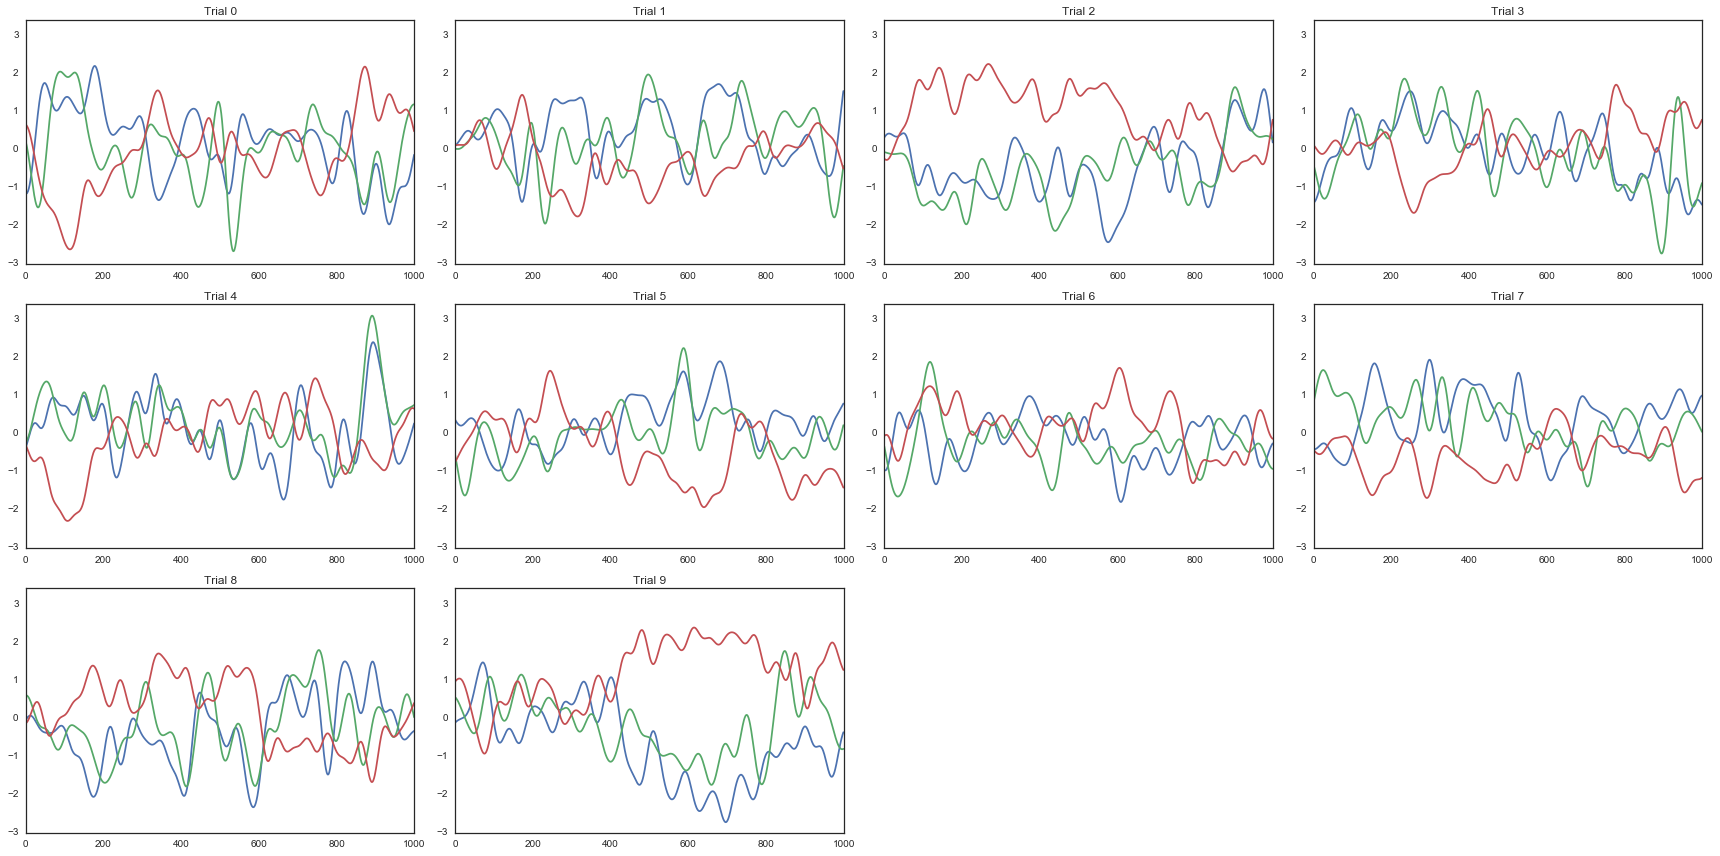

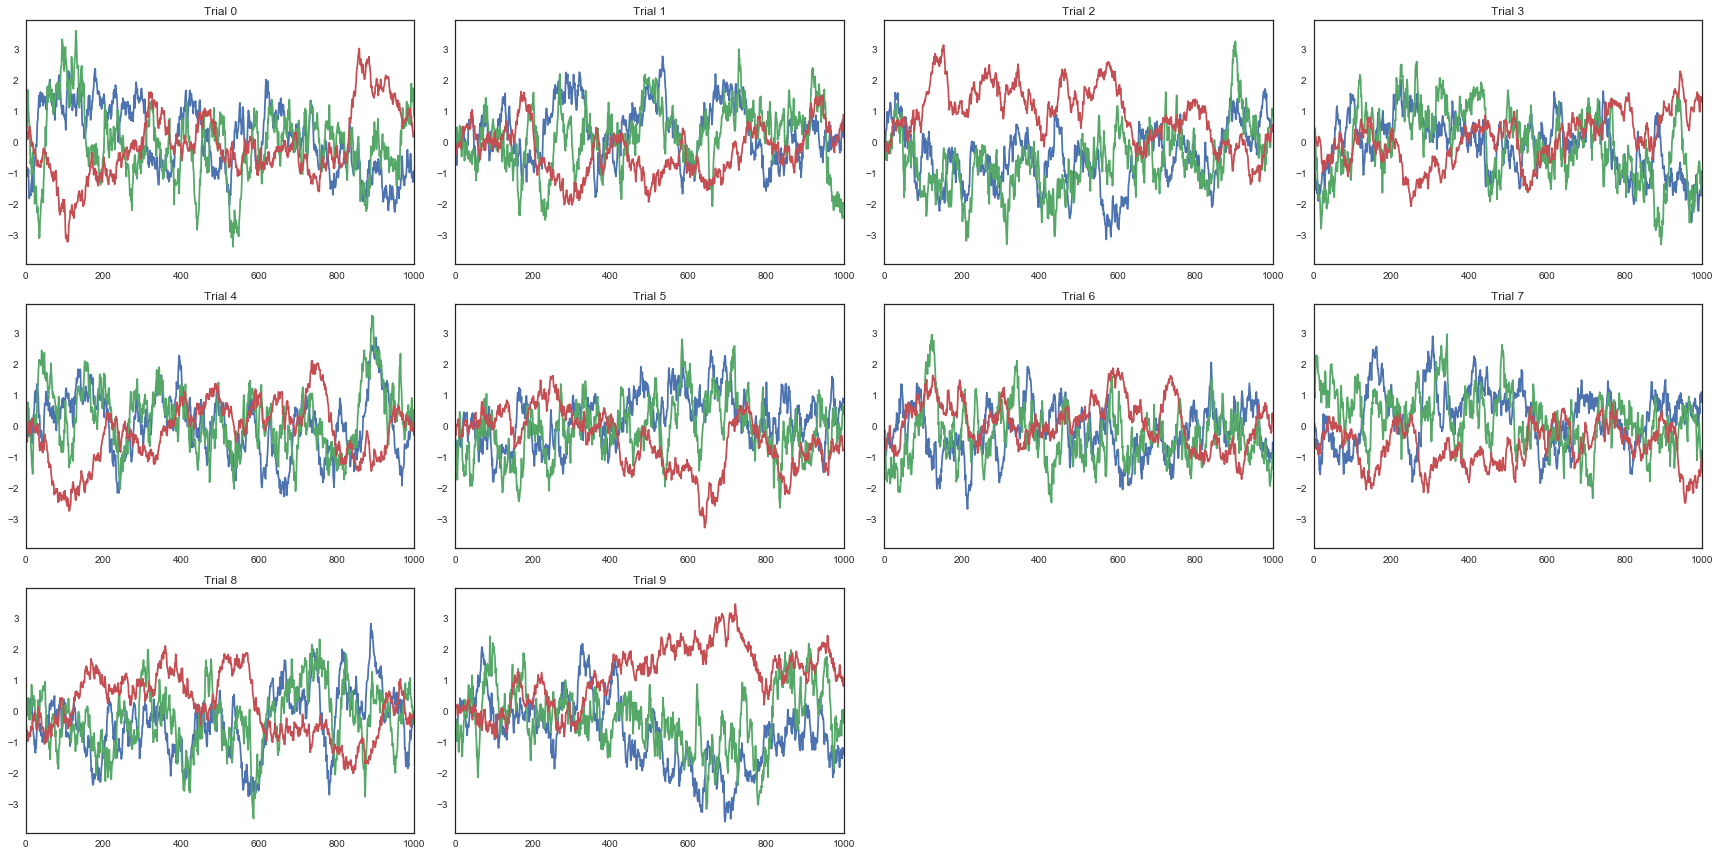

In [479]:
idx = np.array([r['latentAngle'][-1] for r in PLDS_vLGP]).argmin()
# idx = 2
print('Sample {}'.format(idx + 1))
bestvLGP = PLDS_vLGP[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['loadingAngle'][-1])))
# bestvLGPx = util.align(bestvLGP['mu'])
bestvLGPx = bestvLGP['mu']
rotated = np.empty_like(bestvLGPx)
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestvLGPx[i, :]), bestvLGP['x'][i, :])

# rotated = util.align(rotated)
# print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestvLGP['x'].reshape((-1, nlatent)))))
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestvLGP['x'])

# fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
# recon = rotated.reshape((-1, nlatent))
# ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
# ax[0].set_xlim3d(-1, 1);
# ax[0].set_ylim3d(-1, 1);
# ax[0].set_zlim3d(-1, 1);
# ax[0].set_title('Proposed reconstruction of Sample {}'.format(idx + 1));
# ax[1].plot(bestvLGP['x'].reshape((-1, nlatent))[:, 0], bestvLGP['x'].reshape((-1, nlatent))[:, 1], bestvLGP['x'].reshape((-1, nlatent))[:, 2], lw=1);
# ax[1].set_xlim3d(-1, 1);
# ax[1].set_ylim3d(-1, 1);
# ax[1].set_zlim3d(-1, 1);
# ax[1].set_title('True latent of Sample {}'.format(idx + 1));